In [1]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

/scratch/local/2653823/ipykernel_65877/2258313207.py:1: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/2653823/ipykernel_65877/2258313207.py:1: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/2653823/ipykernel_65877/2258313207.py:1: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_peaks` and will be removed in the future. Instead, please use `from photutils.detection import find_peaks` to 

In [2]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [4]:
from astropy.io import fits

In [5]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [6]:
from astroquery.svo_fps import SvoFps

In [7]:
import numpy as np

In [8]:
import reproject

In [9]:
from astropy import units as u

In [10]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [11]:
fh_405 = fits.open(f'{basepath}/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits')
fh_410 = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits')

In [12]:
ls -lh /orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits

-rw-r--r-- 1 adamginsburg adamginsburg 179M Jun 29 10:40 /orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits


In [13]:
ls -lh /orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits

-rw-r--r-- 1 adamginsburg adamginsburg 179M Jun 29 10:38 /orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits


# June 26, 2023: use realigned-to-refcat b/c header of i2d is no longer updated

In [14]:
fh_405 = fits.open(f'{basepath}/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_realigned-to-refcat.fits')
fh_410 = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_realigned-to-refcat.fits')

In [15]:
ww405 = wcs.WCS(fh_405['SCI'].header)
ww410 = wcs.WCS(fh_410['SCI'].header)

Set OBSGEO-B to   -20.699276 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526856902.549 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.643813 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526204922.487 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [16]:
instrument = fh_405[0].header['INSTRUME']
telescope = fh_405[0].header['TELESCOP']
filt405 = fh_405[0].header['PUPIL']
wavelength_table_405 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt405}')
filt410 = fh_410[0].header['FILTER']
wavelength_table_410 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt410}')

In [17]:
filt405, filt410

('F405N', 'F410M')

In [18]:
waves_410 = wavelength_table_410['Wavelength']
trans_405 = np.interp(waves_410, wavelength_table_405['Wavelength'], wavelength_table_405['Transmission'])
trans_410 = wavelength_table_410['Transmission']

Text(0.5, 0, 'Wavelength [Angstroms]')

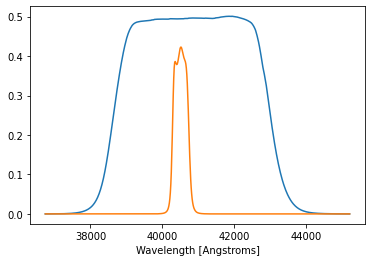

In [19]:
pl.plot(waves_410, trans_410)
pl.plot(waves_410, trans_405)
pl.xlabel("Wavelength [Angstroms]")

In [20]:
fractional_bandwidth_405 = ( (trans_410/trans_410.max()) * (trans_405/trans_405.max()) ).sum() / (trans_410/trans_410.max()).sum()

In [21]:
data_405_proj_410 = reproject.reproject_exact(fh_405['SCI'], fh_410['SCI'].header)

In [22]:
cont410_sub_bra = fh_410['SCI'].data - data_405_proj_410[0]*fractional_bandwidth_405
fits.PrimaryHDU(data=cont410_sub_bra, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F410_minus_F405_nrcb.fits', overwrite=True)

In [23]:
bra_minus_cont = data_405_proj_410[0] - cont410_sub_bra #* fractional_bandwidth_405
fits.PrimaryHDU(data=bra_minus_cont, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F405_minus_F410cont_nrcb.fits', overwrite=True)

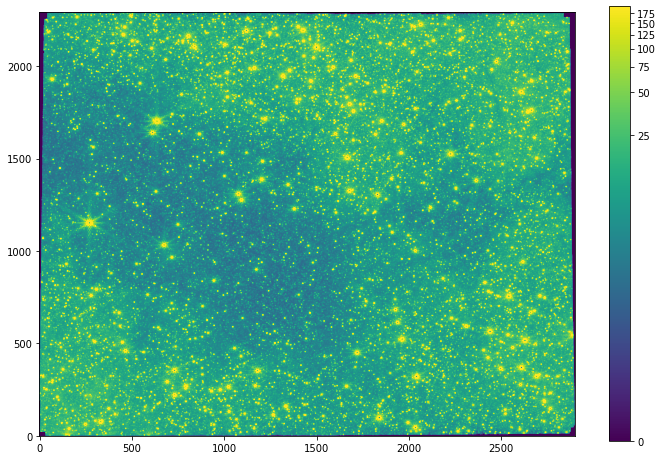

In [24]:
pl.figure(figsize=(12,8))
pl.imshow(fh_410['SCI'].data, norm=simple_norm(cont410_sub_bra, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

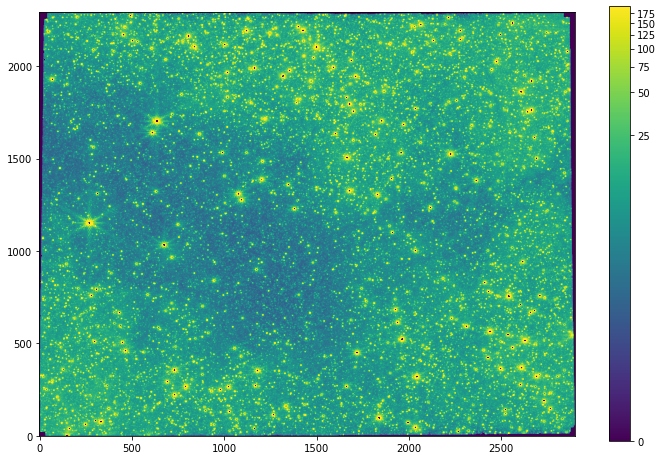

In [25]:
pl.figure(figsize=(12,8))
pl.imshow(cont410_sub_bra, norm=simple_norm(cont410_sub_bra, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

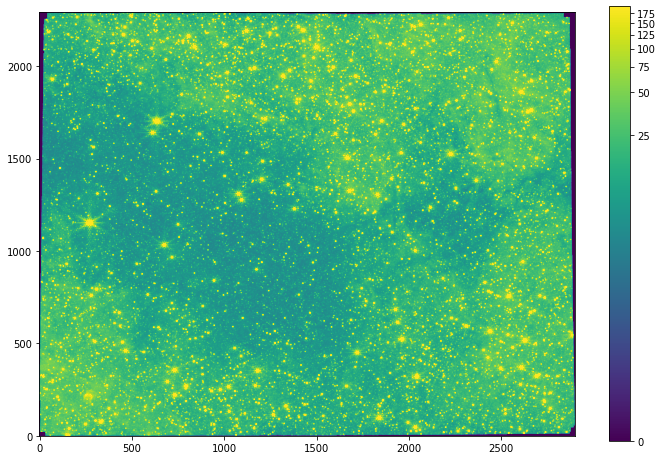

In [26]:
pl.figure(figsize=(12,8))
pl.imshow(fh_405['SCI'].data, norm=simple_norm(cont410_sub_bra, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

## There should not be half-moon artifacts on the left & right side of this image

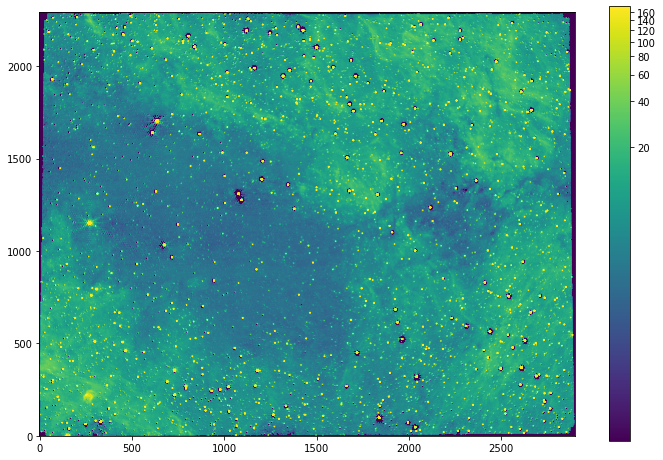

In [27]:
pl.figure(figsize=(12,8))
pl.imshow(bra_minus_cont, norm=simple_norm(bra_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

In [28]:
stars_bra = DAOStarFinder(threshold=60, fwhm=2.302, peakmax=1e4)(fh_405['SCI'].data)
stars_bra['skycoord'] = ww405.pixel_to_world(stars_bra['xcentroid'], stars_bra['ycentroid'])
len(stars_bra)

11848

In [29]:
stars_410 = DAOStarFinder(threshold=10, fwhm=2.302, peakmax=900)(fh_410['SCI'].data)
stars_410['skycoord'] = ww410.pixel_to_world(stars_410['xcentroid'], stars_410['ycentroid'])
len(stars_410)

50693

In [30]:
matches, sep, _ = stars_bra['skycoord'].match_to_catalog_sky(stars_410['skycoord'], nthneighbor=1)

for cn in stars_bra.colnames:
    stars_bra.rename_column(cn, f"{cn}_405")
for cn in stars_410.colnames:
    stars_410.rename_column(cn, f"{cn}_410")
                         
stars_bra.add_column(name="sep_410_405", col=sep)
stars_bra.add_column(name="id_410_405", col=matches)
mergetbl = table.hstack([stars_bra, stars_410[matches]], join_type='exact')

(array([1.041e+04, 4.930e+02, 4.280e+02, 3.980e+02, 7.900e+01, 2.300e+01,
        9.000e+00, 5.000e+00, 1.000e+00, 2.000e+00]),
 array([3.58140745e-04, 1.35477322e-01, 2.70596503e-01, 4.05715685e-01,
        5.40834866e-01, 6.75954047e-01, 8.11073228e-01, 9.46192410e-01,
        1.08131159e+00, 1.21643077e+00, 1.35154995e+00]),
 <BarContainer object of 10 artists>)

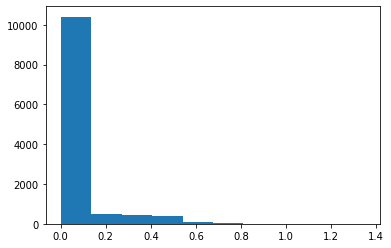

In [31]:
pl.hist(mergetbl['sep_410_405'].to(u.arcsec).value)

(-0.5, 0.5, -0.5, 0.5)

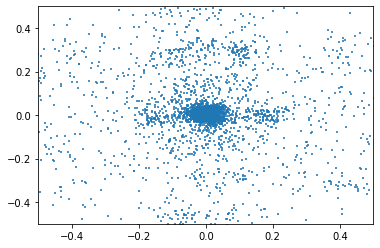

In [32]:
radiff = (mergetbl['skycoord_405'].ra - mergetbl['skycoord_410'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_405'].dec - mergetbl['skycoord_410'].dec).to(u.arcsec)
pl.scatter(radiff, decdiff, marker=',', s=1, alpha=0.8)
pl.axis([-0.5,0.5,-0.5,0.5])

(-0.05, 0.05, -0.05, 0.05)

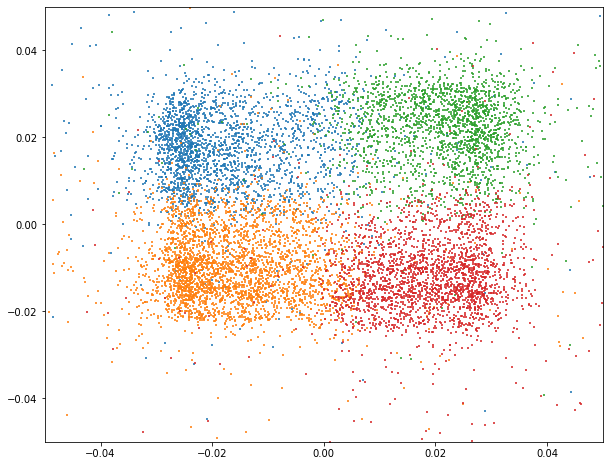

In [33]:
pl.figure(figsize=(10,8))
radiff = (mergetbl['skycoord_405'].ra - mergetbl['skycoord_410'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_405'].dec - mergetbl['skycoord_410'].dec).to(u.arcsec)
topleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] > 1024)
pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.8)
topright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] > 1024)
pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.8)
bottomleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] < 1024)
pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.8)
bottomright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] < 1024)
pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.8)
pl.axis([-0.05,0.05,-0.05,0.05])

In [34]:
mergetbl['xcentroid_405'].max(), mergetbl['ycentroid_405'].max()

(2894.5361306736104, 2289.56382564346)

In [35]:
dist_from_center = ((mergetbl['xcentroid_405'] - 1450)**2 + (mergetbl['ycentroid_405'] - 1145)**2)**0.5

Text(0, 0.5, 'Offset from F410 (arcseconds)')

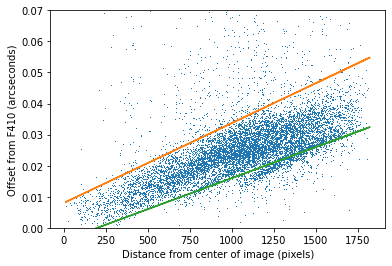

In [36]:
pl.plot(dist_from_center, mergetbl['sep_410_405'].to(u.arcsec).value, ',')
pl.plot(dist_from_center, dist_from_center/1750 * 0.045 + 0.008)
pl.plot(dist_from_center, dist_from_center/1750 * 0.035 - 0.004)
pl.ylim(0,0.07)
pl.xlabel("Distance from center of image (pixels)")
pl.ylabel("Offset from F410 (arcseconds)")

# The distortion is nearly linear!

In [37]:
ok = (mergetbl['sep_410_405'] < 0.05*u.arcsec) & (mergetbl['sep_410_405'] < (dist_from_center/1750*0.045 +0.08) *u.arcsec) & (mergetbl['sep_410_405'] > (dist_from_center/1750*0.035 - 0.08) *u.arcsec)

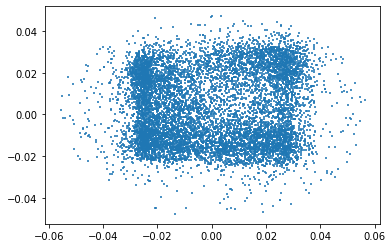

In [38]:
radiff = (mergetbl['skycoord_405'].ra - mergetbl['skycoord_410'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_405'].dec - mergetbl['skycoord_410'].dec).to(u.arcsec)
pl.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.8)

In [39]:
from astropy.wcs.utils import fit_wcs_from_points

In [40]:
ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok], mergetbl['ycentroid_405'][ok]], mergetbl['skycoord_410'][ok], sip_degree=1)

In [41]:
ww_410_refit = fit_wcs_from_points([mergetbl['xcentroid_410'][ok], mergetbl['ycentroid_410'][ok]], mergetbl['skycoord_405'][ok], sip_degree=3)

In [42]:
skycoord_410_refit = ww_410_refit.pixel_to_world(mergetbl['xcentroid_410'], mergetbl['ycentroid_410'])

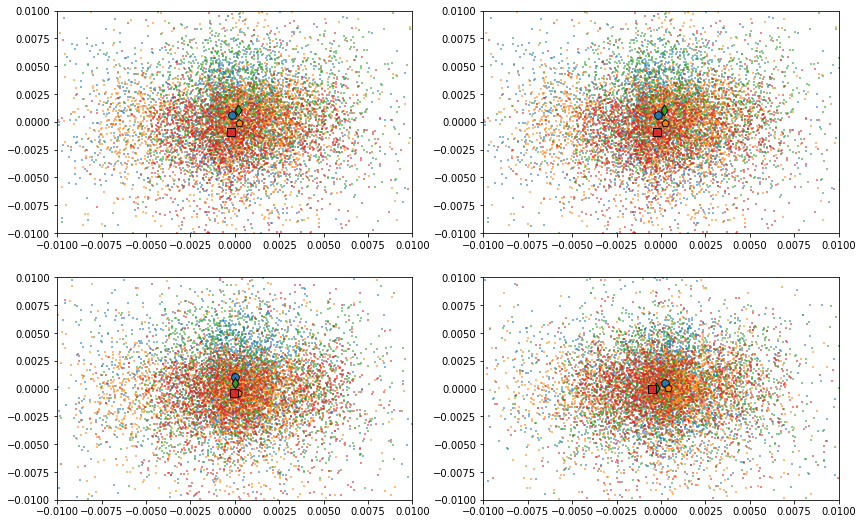

In [43]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    
    ww_410_refit = fit_wcs_from_points([mergetbl['xcentroid_410'][ok], mergetbl['ycentroid_410'][ok]], mergetbl['skycoord_405'][ok], sip_degree=sip_degree)
    skycoord_410_refit = ww_410_refit.pixel_to_world(mergetbl['xcentroid_410'], mergetbl['ycentroid_410'])
    radiff = (mergetbl['skycoord_405'].ra - skycoord_410_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_405'].dec - skycoord_410_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_410_refit = fit_wcs_from_points([mergetbl['xcentroid_410'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_410'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_405'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_410_refit = ww_410_refit.pixel_to_world(mergetbl['xcentroid_410'], mergetbl['ycentroid_410'])
    radiff = (mergetbl['skycoord_405'].ra - skycoord_410_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_405'].dec - skycoord_410_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

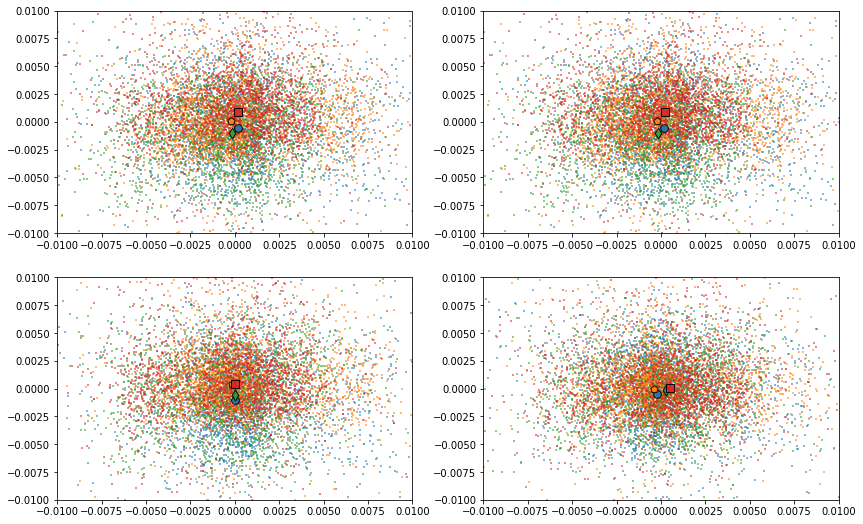

In [44]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    
    ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok], mergetbl['ycentroid_405'][ok]], mergetbl['skycoord_410'][ok], sip_degree=sip_degree)
    skycoord_405_refit = ww_405_refit.pixel_to_world(mergetbl['xcentroid_405'], mergetbl['ycentroid_405'])
    radiff = (mergetbl['skycoord_410'].ra - skycoord_405_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_410'].dec - skycoord_405_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_405'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_410'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_405_refit = ww_405_refit.pixel_to_world(mergetbl['xcentroid_405'], mergetbl['ycentroid_405'])
    radiff = (mergetbl['skycoord_410'].ra - skycoord_405_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_410'].dec - skycoord_405_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_405'] < 1424) & (mergetbl['ycentroid_405'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_405'] > 1424) & (mergetbl['ycentroid_405'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

In [45]:
sip_degree = 3
ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok], mergetbl['ycentroid_405'][ok]], mergetbl['skycoord_410'][ok], sip_degree=sip_degree)
skycoord_405_refit = ww_405_refit.pixel_to_world(mergetbl['xcentroid_405'], mergetbl['ycentroid_405'])
radiff = (mergetbl['skycoord_410'].ra - skycoord_405_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_410'].dec - skycoord_405_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5
ww_405_refit = fit_wcs_from_points([mergetbl['xcentroid_405'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_405'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_410'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
skycoord_405_refit = ww_405_refit.pixel_to_world(mergetbl['xcentroid_405'], mergetbl['ycentroid_405'])
radiff = (mergetbl['skycoord_410'].ra - skycoord_405_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_410'].dec - skycoord_405_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5


In [46]:
ww_405_refit.to_header(relax=True).totextfile(f'{basepath}/reduction/headers/f405n_nrcb_refitted_to_f410m.hdr', overwrite=True)

In [47]:
data_405_proj_410_refit, overlap_refit = reproject.reproject_exact((fh_405['SCI'].data, ww_405_refit), fh_410['SCI'].header)

Set OBSGEO-B to   -20.643813 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526204922.487 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [48]:
fits.PrimaryHDU(data=data_405_proj_410_refit, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F405_refitted405wcsto410_nrcb.fits', overwrite=True)

In [49]:
cont410_sub_bra = fh_410['SCI'].data - data_405_proj_410_refit*fractional_bandwidth_405
fits.PrimaryHDU(data=cont410_sub_bra, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F410_minus_F405_refitted405wcsto410_nrcb.fits', overwrite=True)

In [50]:
bra_minus_cont = data_405_proj_410_refit - cont410_sub_bra #* fractional_bandwidth_405
fits.PrimaryHDU(data=bra_minus_cont, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrcb.fits', overwrite=True)

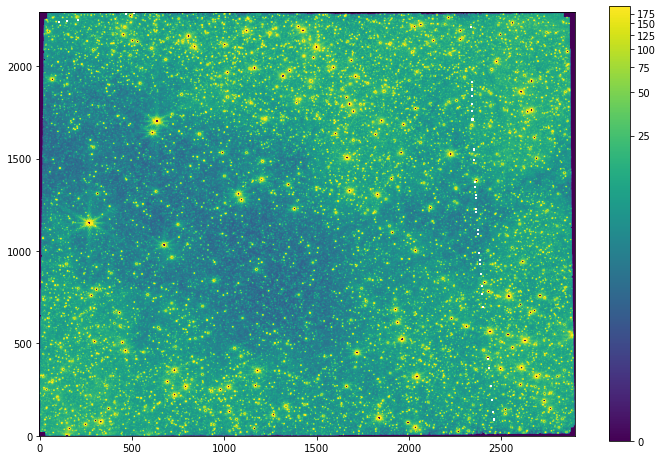

In [51]:
pl.figure(figsize=(12,8))
pl.imshow(cont410_sub_bra, norm=simple_norm(cont410_sub_bra, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

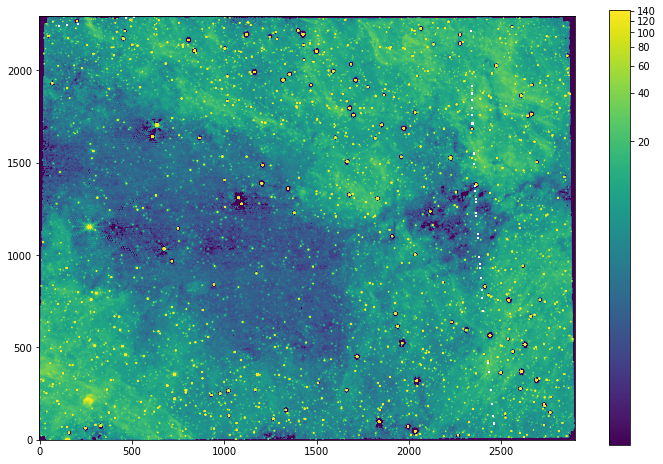

In [52]:
pl.figure(figsize=(12,8))
pl.imshow(bra_minus_cont, norm=simple_norm(bra_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

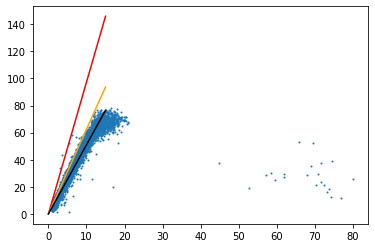

In [53]:
xr = np.linspace(0,15)
pl.scatter(mergetbl['flux_405'][ok], mergetbl['flux_410'][ok], s=1)
pl.plot(xr, xr/fractional_bandwidth_405, color='red')
scalefactor = 0.16
pl.plot(xr, xr/scalefactor, color='orange')
post_destreak_scalefactor = 0.196
pl.plot(xr, xr/post_destreak_scalefactor, color='black')

In [54]:
latest_scalefactor = np.median(1/(mergetbl['flux_410'][ok]/mergetbl['flux_405'][ok]))

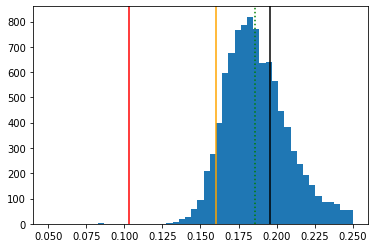

In [55]:
pl.hist(1/(mergetbl['flux_410'][ok]/mergetbl['flux_405'][ok]), bins=np.linspace(0.05,0.25))
pl.axvline(scalefactor, color='orange')
pl.axvline(post_destreak_scalefactor, color='black')
pl.axvline(fractional_bandwidth_405, color='red')
pl.axvline(latest_scalefactor, color='green', linestyle=':')

In [56]:
cont410_sub_bra = fh_410['SCI'].data - data_405_proj_410_refit*latest_scalefactor
fits.PrimaryHDU(data=cont410_sub_bra, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F410_minus_F405_refitted405wcsto410_nrcb.fits', overwrite=True)

In [57]:
bra_minus_cont = data_405_proj_410_refit - cont410_sub_bra #* fractional_bandwidth_405
fits.PrimaryHDU(data=bra_minus_cont, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F405_minus_F410cont_refitted405wcsto410_nrcb.fits', overwrite=True)